In [2]:
# Standard imports
import copy
import corner
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Astropy imports
from astropy.table import Table

# Lenstronomy, HierArc imports
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Likelihood.LensLikelihood.double_source_plane import beta2theta_e_ratio, beta_double_source_plane

# set global plotting parameters for academic paper
# plt.rcParams.update({
#     "font.size": 12,
#     "axes.labelsize": 14,
#     "axes.titlesize": 14,
#     "xtick.labelsize": 12,
#     "ytick.labelsize": 12,
#     "legend.fontsize": 12,
#     "figure.titlesize": 16,
#     "figure.figsize": (8, 6),
#     "lines.linewidth": 1.5,
#     "lines.markersize": 6,
#     "font.family": "serif",
#     "text.usetex": True,
# })

# Fit plane to the data
def fit_plane(x, y, z):
    """Fit a plane to the data points (x, y, z). The plane is z = ax + by + c."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    A = np.c_[x, y, np.ones_like(x)]
    coeffs, _, _, _ = np.linalg.lstsq(A, z, rcond=None)
    return coeffs

# Find the scatter of the data points from the fitted plane
def find_scatter(x, y, z, coeffs, return_fit=False):
    """Find the scatter of the data points from the fitted plane. Return ``z - z_fit``."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    z_fit = coeffs[0] * x + coeffs[1] * y + coeffs[2]
    scatter = z - z_fit
    if return_fit:
        return scatter, z_fit
    else:
        return scatter

In [3]:
# load the GGL data tables with different sky areas of lenses bu galaxy population is on 10 deg^2
sky_areas = ["30.0v2", "50.0v2"]
GGL_data_tables = [Table.read(f"../data/GGL_{area}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE.fits", format='fits') for area in sky_areas]
GGL_data_tables = {area: table for area, table in zip(sky_areas, GGL_data_tables)}

# add the 30deg all sky areas same table
# GGL_data_tables["30.0v2"] = Table.read("../data/GGL_30.0_SQDEG_RED_DEFLECTOR_BLUE_SOURCE_all_sky_areas_same.fits", format='fits')


# limits on the magnitudes for LSST 10 year survey ~ 26
LIMIT_BY_MAGNITUDE = False
if LIMIT_BY_MAGNITUDE:
    mag_limits = {
        "i": 26.6,
        "r": 27.5,
        "g": 27.4,
        "z": 26.1,
        "y": 24.9
    } # \citep{Bianco:2022}
    new_GGL_data_tables = {}
    for sky_area in GGL_data_tables.keys():
        # filter the data table to only include galaxies with magnitudes less than the limits
        mask = np.ones(len(GGL_data_tables[sky_area]), dtype=bool)
        for band, limit in mag_limits.items():
            mask &= GGL_data_tables[sky_area][f"mag_D_{band}"] < limit
            mask &= GGL_data_tables[sky_area][f"mag_S_{band}"] < limit
        new_GGL_data_tables[sky_area] = GGL_data_tables[sky_area][mask]

    GGL_data_tables = new_GGL_data_tables

GGL_data_tables["50.0"]

KeyError: '50.0'

In [4]:
# fit the MFP for each dataset

coeffs_MFP_tables = {}
scatters_MFP_tables = {}
for sky_area, GGL_data_table in GGL_data_tables.items():
    # fit the MFP
    coeffs_MFP = fit_plane(
        np.log10(GGL_data_table["R_e_kpc"]),
        np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
        np.log10(GGL_data_table["sigma_v_D"])
    )
    coeffs_MFP_tables[sky_area] = coeffs_MFP
    # find the scatter
    scatter_MFP = find_scatter(
        np.log10(GGL_data_table["R_e_kpc"]),
        np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
        np.log10(GGL_data_table["sigma_v_D"]),
        coeffs_MFP,
        return_fit=False
    )
    scatters_MFP_tables[sky_area] = scatter_MFP

In [5]:
# make bins on the R_e vs Sigma_half plane and make pairings
# then compute the scatter in sigma_v_D from pairings
# and also the scatter in beta_E from pairings

num_bins = 20  # number of bins


# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)


# store pairing data template 
individual_pair_data = {
    'beta_E_pseudo': [],
    'beta_E_DSPL': [],
    'z_D1': [],
    'z_D2': [],
    'z_S1': [],
    'z_S2': [],
    'sigma_v_D1': [],
    'sigma_v_D2': [],
    'lens1_id': [],
    'lens2_id': [],
}


individual_pair_data_tables = {sky_area: copy.deepcopy(individual_pair_data) for sky_area in GGL_data_tables.keys()}

# loop over the sky areas
for sky_area, GGL_data_table in tqdm(GGL_data_tables.items(), desc="Processing GGLs", total=len(GGL_data_tables)):
    # make bins on the R_e vs Sigma_half plane
    x = np.log10(GGL_data_table["R_e_kpc"])
    y = np.log10(GGL_data_table["Sigma_half_Msun/pc2"])

    x_bins = np.linspace(np.nanmin(x), np.nanmax(x), num_bins)
    y_bins = np.linspace(np.nanmin(y), np.nanmax(y), num_bins)

    # make pairings
    for i in tqdm(range(len(x_bins) - 1)):
        for j in range(len(y_bins) - 1):
            mask = (
                (x >= x_bins[i]) & (x < x_bins[i + 1]) &
                (y >= y_bins[j]) & (y < y_bins[j + 1])
            )
            if np.sum(mask) < 2:
                continue
            
            # get the data points in this bin
            data_points = GGL_data_table[mask]
            
            # make pairings
            for lens1, lens2 in combinations(data_points, 2):
                beta_E_pseudo = lens1['theta_E'] / lens2['theta_E']

                # check z_lens < z_source
                if lens1['z_D'] >= lens2['z_S'] or lens2['z_D'] >= lens1['z_S']:
                    continue

                beta_DSPL = beta_double_source_plane(
                    z_lens = np.mean([lens1['z_D'], lens2['z_D']]),
                    z_source_1= lens1['z_S'],
                    z_source_2= lens2['z_S'],
                    cosmo = cosmo_true,
                )
                beta_E_DSPL = beta2theta_e_ratio(
                    beta_dsp= beta_DSPL,
                    gamma_pl= 2, #TODO: what if gamma_pl != 2?
                    lambda_mst= 1
                )

                individual_pair_data_tables[sky_area]['beta_E_pseudo'].append(beta_E_pseudo)
                individual_pair_data_tables[sky_area]['beta_E_DSPL'].append(beta_E_DSPL)
                individual_pair_data_tables[sky_area]['z_D1'].append(lens1['z_D'])
                individual_pair_data_tables[sky_area]['z_D2'].append(lens2['z_D'])
                individual_pair_data_tables[sky_area]['z_S1'].append(lens1['z_S'])
                individual_pair_data_tables[sky_area]['z_S2'].append(lens2['z_S'])
                individual_pair_data_tables[sky_area]['sigma_v_D1'].append(lens1['sigma_v_D'])
                individual_pair_data_tables[sky_area]['sigma_v_D2'].append(lens2['sigma_v_D'])
                individual_pair_data_tables[sky_area]['lens1_id'].append(lens1['lens_id'])
                individual_pair_data_tables[sky_area]['lens2_id'].append(lens2['lens_id'])

# convert to astropy tables
individual_pair_data_tables = {sky_area: Table(data=data) for sky_area, data in individual_pair_data_tables.items()}

Processing GGLs: 100%|██████████| 2/2 [00:16<00:00,  8.42s/it]


In [6]:
# print the scatter in sigma_v_D for pairs with |z_D1 - z_D2| < 0.01
for sky_area, individual_pair_data_table in individual_pair_data_tables.items():
    print(f"================= Sky Area: {sky_area} sq. deg. =================")
    mask = np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) < 0.01
    print(f"# of pairs with |z_D1 - z_D2| < 0.01: {np.sum(mask)}")
    sigma_v_scatter = np.std(individual_pair_data_table[mask]['sigma_v_D1'] - individual_pair_data_table[mask]['sigma_v_D2']) / (np.mean(individual_pair_data_table[mask]['sigma_v_D1'] + individual_pair_data_table[mask]['sigma_v_D2']) / 2)
    print(f"Relative scatter in σᵥ: {sigma_v_scatter:.3f}")
    
    # scatter in beta_E
    beta_E_scatter = np.std(1 - individual_pair_data_table[mask]['beta_E_pseudo']/individual_pair_data_table[mask]['beta_E_DSPL'])
    print(f"Relative scatter in β_E: {beta_E_scatter:.3f}")
    print()  # for better readability

================= Sky Area: 30.0v2 sq. deg. =================
# of pairs with |z_D1 - z_D2| < 0.01: 1401
Relative scatter in σᵥ: 0.084
Relative scatter in β_E: 0.176

================= Sky Area: 50.0v2 sq. deg. =================
# of pairs with |z_D1 - z_D2| < 0.01: 5751
Relative scatter in σᵥ: 0.080
Relative scatter in β_E: 0.162



In [54]:
# save the individual pair data tables
for sky_area, individual_pair_data_table in individual_pair_data_tables.items():
    individual_pair_data_table.write(f"../data/PDSPL_GGL_PAIRS_{sky_area}_SQDEG_RED_DEFLECTOR_BLUE_SOURCES.fits", format='fits', overwrite=True)

### Plot Histogram of the scatter in sigma_v_D and the scatter in beta_E for all datasets

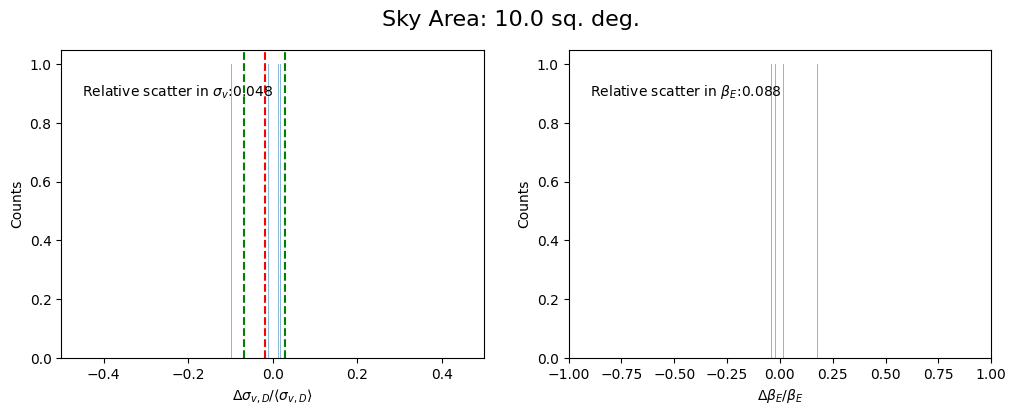

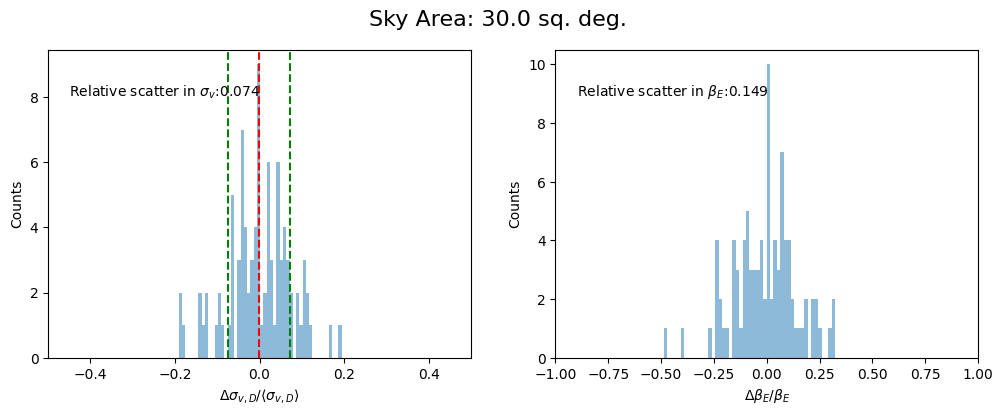

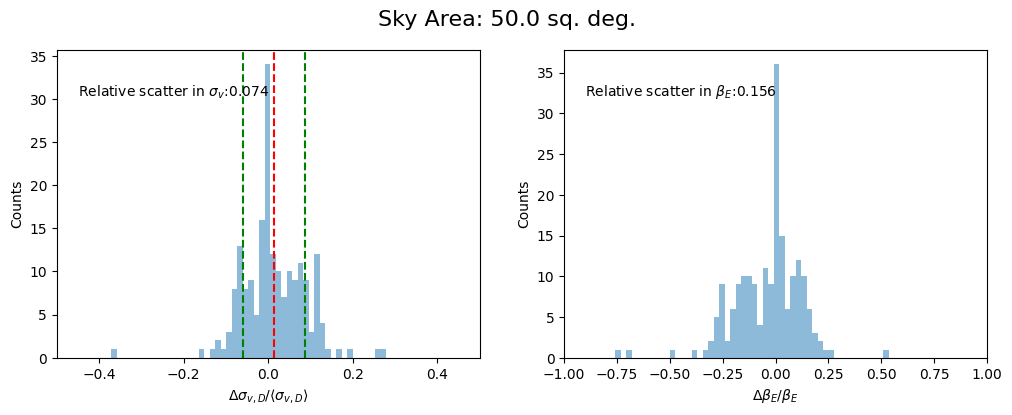

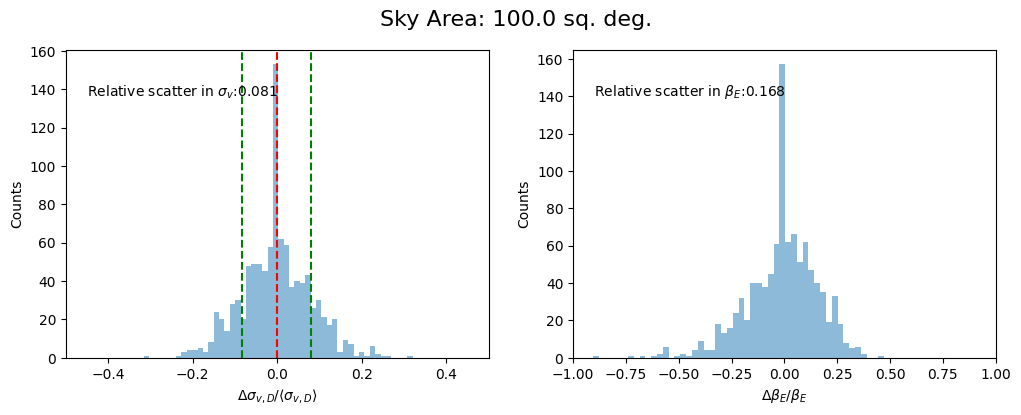

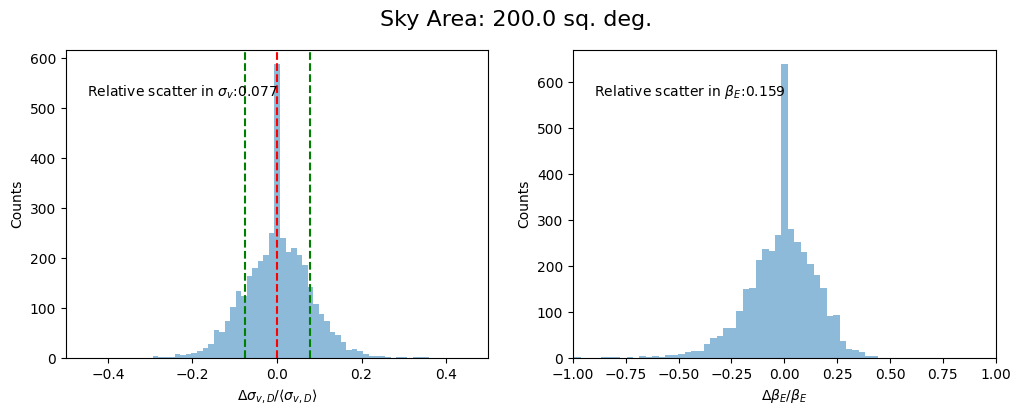

In [37]:
### Plot Histogram of the scatter in sigma_v_D and the scatter in beta_E for all datasets

for sky_area, individual_pair_data_table in individual_pair_data_tables.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    mask = np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) < 0.01
    individual_pair_data_table = individual_pair_data_table[mask]
    
    rel_sigma_v = individual_pair_data_table['sigma_v_D1'] - individual_pair_data_table['sigma_v_D2']
    rel_sigma_v /= (individual_pair_data_table['sigma_v_D1'] + individual_pair_data_table['sigma_v_D2']) / 2
    axes[0].hist(rel_sigma_v, bins=50, alpha=0.5, label='$\\Delta \\sigma_{v, D}/ \\langle \\sigma_{v, D} \\rangle$')
    axes[0].set_xlabel('$\\Delta \\sigma_{v, D}/ \\langle \\sigma_{v, D} \\rangle$')
    axes[0].set_ylabel('Counts')
    axes[0].set_xlim(-0.5, 0.5)
    axes[0].text(0.05, 0.85, f'Relative scatter in $\\sigma_v$:{np.std(rel_sigma_v):.3f}', transform=axes[0].transAxes)

    # fit a gaussian to the scatter
    axes[0].axvline(np.mean(rel_sigma_v), color='red', linestyle='--', label='Mean')
    axes[0].axvline(np.mean(rel_sigma_v) + np.std(rel_sigma_v), color='green', linestyle='--', label='Mean + Std Dev')
    axes[0].axvline(np.mean(rel_sigma_v) - np.std(rel_sigma_v), color='green', linestyle='--', label='Mean - Std Dev')


    rel_beta_E = (individual_pair_data_table['beta_E_DSPL'] - individual_pair_data_table['beta_E_pseudo'])/individual_pair_data_table['beta_E_DSPL']
    axes[1].hist(rel_beta_E, bins=50, alpha=0.5, label='$\\Delta \\beta_E / \\beta_E$')
    axes[1].set_xlabel('$\\Delta \\beta_E / \\beta_E$')
    axes[1].set_ylabel('Counts')
    axes[1].set_xlim(-1, 1)
    axes[1].text(0.05, 0.85, f'Relative scatter in $\\beta_E$:{np.std(rel_beta_E):.3f}', transform=axes[1].transAxes)
    
    fig.suptitle(f'Sky Area: {sky_area} sq. deg.', fontsize=16)
    